<h1 align="center"> Amazon Food Reivew</h1>

## Introduction:                    
The Amazon Food Review data is an open dataset that found at [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews). This dataset consists of reviews of foods from Amazon. The data includes reviews 568,545 reviews from 256,059 users spans from Oct 1999 to Oct 2012.       

The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation.
     
## Goals:         
- Create new variables and convert variable types          
- Generate word cloud to get sense of the review          
- Exploratory data analysis for key variables
- Explore the relationship between key variables       
- Create Bag of Words using three different methods     
- Build logistic regression and random forest regression model and find the one performs the best

## Outline
- <b>1.Data Cleaning and Preprocessing</b>  
 - 1.1 Loading data               
 - 1.2 Create New Variables and Convert Variable Types             
 - 1.3 Build Term-doc incidence matrix            
    - a) stopwords              
    - b) Stemming                  
    - c) punctuaion removal               
 - 1.4 create cloud word             
             
                 
- <b>2. Exploratory Data Analysis</b>      
 - 2.1 Descriptive Statistics                
 - 2.2 Socre analysis                 
 - 2.3 Sentiment analysis          
 - 2.4 Usefulness analysis        
 - 2.5 Reviewers analysis         
 - 2.6 Relationship analysis between variables
   - a)Are positive reveiws more helpful?
   - b)Are frequent reviewers more helpful? 
             
             
- <b>3. Predictive Modeling</b>   
 - 3.1 Test train data split                   
 - 3.2 Convert text to vector                 
     - a) Uni-gram bag of words
     - b) Bi-gram bag of words
     - c) tf-idf
 - 3.3 Logistic Regression
   - a) Using Uni-gram bag of words
   - b) Using bi-gram bag of words
   - c) using tf-idf
 - 3.4 Random Forest Regression              
   - a) Using Uni-gram bag of words
   - b) Using bi-gram bag of words
   - c) using tf-idf                   
                   
                   
- <b>4. Predicition Evaluation</b>       
    - 4.1 Comparison of logistic regression models
        - a) Comparison of Classification report         
        - b) Comparison of AUC values
        - c) Comparison of ROC Curve
    - 4.2 Comparison of random forest regression models
        - a) Comparison of Classification report         
        - b) Comparison of AUC values
        - c) Comparison of ROC Curve
    - 4.3 Comparison between Logistic Regression Model and Random Forest Regression Model   
                 
                 
- <b>5. Conclusion</b>  

                  
                  



## 1. Data Cleaning and Preprocessing

### Summary           
3 new variables and their levels were created:
- sentiment: Reviews scored above 3 were treated as positive and reviews under 3 were treated as negative.
- helpfulness: the percentage of reviews that people voted for helpfulness. 4 levels of helpfulness were defined.
- UserFrequency: how frequency of a user submits reviews. 2 levels of userfrequency were defined.              

We performed three operations on the data to format our data and build the Term-doc incidence matrix: stop words and punctuation removal, stemming, and lowering letter cases.     
     
At the end of this section, cloud words were generated to give a sense of the review data. 

### 1.1 Gather Sense of Data
The first thing to do is to get a sense of our data. The data includes 568,545 reviews from 256,059 users. The Id, ProductId, and Time data do not relate to the purpose of this project, so we will not use them. The summary variable is the extract from the text so we will use the summary in the model instead of using Text. 

#### Loading data

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 1.2 Create New Variables and Convert Variable Types

Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.            

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative".          




In [4]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")

Similarly, the **Usefulness** column turns the number of votes into a boolean. We can use **HelpfulnessNumerator** and **HelpfulnessDenominator** to create level of usefulness

In [5]:
df["Usefulness"] = (df["HelpfulnessNumerator"]/df["HelpfulnessDenominator"]).apply\
    (lambda n: ">75%(very helpful)" if n > 0.75
         else ("25%-75% (helpful)" if n >= 0.25 and n <= 0.75
             else ("<25% (little helpful)" if n < 0.25
                 else "=0 (useless)")))

Then we count the frequency of **UserID**

In [6]:
n = df.UserId.value_counts()
df['UserFrequency'] = df['UserId'].apply \
    (lambda counts: 'frequent reviewer (>100 reviews)' if n[counts] > 100 
            else 'Not frequent reviewer (0-100 reviews)')

Let's select some subcolumns that we will use for the analysis

In [7]:
df = df[['Id', 'Score', 'Summary', 'Sentiment', 'Usefulness', 'UserFrequency']]
df.head()

,Id,Score,Summary,Sentiment,Usefulness,UserFrequency
0,1,5,Good Quality Dog Food,positive,>75%(very helpful),Not frequent reviewer (0-100 reviews)
1,2,1,Not as Advertised,negative,=0 (useless),Not frequent reviewer (0-100 reviews)
2,3,4,"""Delight"" says it all",positive,>75%(very helpful),Not frequent reviewer (0-100 reviews)
3,4,2,Cough Medicine,negative,>75%(very helpful),Not frequent reviewer (0-100 reviews)
4,5,5,Great taffy,positive,=0 (useless),Not frequent reviewer (0-100 reviews)


ket's look at some 5s:

In [8]:
df[df.Score == 5].head(5)

,Id,Score,Summary,Sentiment,Usefulness,UserFrequency
0,1,5,Good Quality Dog Food,positive,>75%(very helpful),Not frequent reviewer (0-100 reviews)
4,5,5,Great taffy,positive,=0 (useless),Not frequent reviewer (0-100 reviews)
6,7,5,Great! Just as good as the expensive brands!,positive,=0 (useless),Not frequent reviewer (0-100 reviews)
7,8,5,"Wonderful, tasty taffy",positive,=0 (useless),Not frequent reviewer (0-100 reviews)
8,9,5,Yay Barley,positive,>75%(very helpful),Not frequent reviewer (0-100 reviews)


and some 1s as well:

In [9]:
df[df.Score == 1].head(5)

,Id,Score,Summary,Sentiment,Usefulness,UserFrequency
1,2,1,Not as Advertised,negative,=0 (useless),Not frequent reviewer (0-100 reviews)
12,13,1,My Cats Are Not Fans of the New Food,negative,>75%(very helpful),Not frequent reviewer (0-100 reviews)
26,27,1,Nasty No flavor,negative,<25% (little helpful),Not frequent reviewer (0-100 reviews)
50,51,1,Don't like it,negative,<25% (little helpful),Not frequent reviewer (0-100 reviews)
62,63,1,stale product.,negative,>75%(very helpful),Not frequent reviewer (0-100 reviews)


### 1.3 Build Term-odc incidence matrix

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

- Stop words removal
- Stemming
- Punctuations
- Lowering

#### a) Stopwords
* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

![alt text](https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png)

In [10]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
'not' in stop

True

Since not is an important word in the review, thus  **we will not use stopwords removal for the modeling**         
#### b) stemming

In [12]:
# Stemmers remove morphological affixes from words, leaving only the word stem.
from nltk.stem import SnowballStemmer 
snow = SnowballStemmer('english')

let's test a few

In [13]:
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


#### c) punctuations removal

In [14]:
# remove the punctuation from the sentense
import re

test to see how it works

In [15]:
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space

In [16]:
str(sentence)

'Id like to have some coffee today '

### 1.4 Create a Cloud Word

In [17]:
def cleanup(sentence):
    sentence = str(sentence) #convert the sentence to string
    sentence = sentence.lower() #lower the case
    sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space

    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out) #use space to join all token and make them become one object
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out     

Again, we do not use stopwords removal, since stopwords like 'not' for example ,have strong negative signal.      
Let's test a few:

In [18]:
print(cleanup('How are you today?'))
print(cleanup('Not as I expected!'))
print(cleanup(35))

how are you today
not as i expect
35


Let's apply the cleanup on summary variable

In [19]:
import time
start = time.time()

df['Summary_Clean'] = df['Summary'].apply(cleanup)

end = time.time()
print(f'runtime of the program is {end - start}')

runtime of the program is 147.35504937171936


In [20]:
#!pip install wordcloud

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
#        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

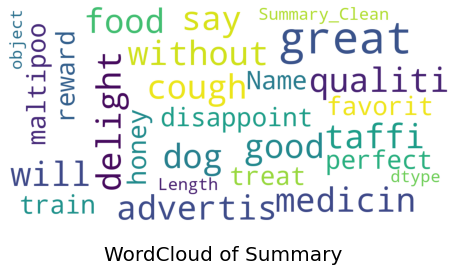

In [22]:
show_wordcloud(df['Summary_Clean'], title = "WordCloud of Summary")

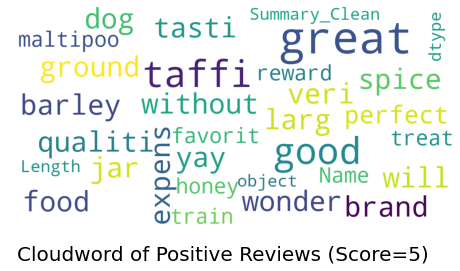

In [23]:
show_wordcloud(df['Summary_Clean'].loc[df.Score == 5], title = "Cloudword of Positive Reviews (Score=5)")

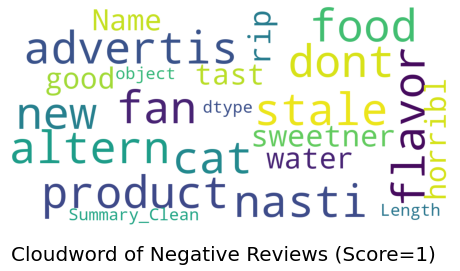

In [24]:
show_wordcloud(df['Summary_Clean'].loc[df.Score == 1], title = "Cloudword of Negative Reviews (Score=1)")

## 2. Exploratory Data Analysis
In this section, we will perform the descriptive statistics and exam any missing value in the data. Then an exploratory data analysis were conducted on variable: score, sentiment, usefulness, userfrequency and relationship between variables. 

### Summary:
- There are 27 "null" data in Summary and 1s "null", compare to the whole dataset, this consider minor and won't affect the result.
- More than half of reviews are 5 scores.
- More positive review than negative reviews.
- More non-frequent reviewers than frequent reviewers.
- Majority reviews are considered very helpful (>75% voted)
- Within the reviews being voted, more positive reviews than negative reviews within in very helpful (>75% voted) reviews, and more negative reviews than positive ones in helpful (25%-75% voted) reviews and little helpful (0-25% voted).

### 2.1 Descriptive Statistics

let's take a look at the dataframe after cleaning and we will conduct EDA on this datafarme

In [25]:
df.head()

,Id,Score,Summary,Sentiment,Usefulness,UserFrequency,Summary_Clean
0,1,5,Good Quality Dog Food,positive,>75%(very helpful),Not frequent reviewer (0-100 reviews),good qualiti dog food
1,2,1,Not as Advertised,negative,=0 (useless),Not frequent reviewer (0-100 reviews),not as advertis
2,3,4,"""Delight"" says it all",positive,>75%(very helpful),Not frequent reviewer (0-100 reviews),delight say it all
3,4,2,Cough Medicine,negative,>75%(very helpful),Not frequent reviewer (0-100 reviews),cough medicin
4,5,5,Great taffy,positive,=0 (useless),Not frequent reviewer (0-100 reviews),great taffi


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df.shape # data shape

(568454, 7)

In [28]:
df.nunique() # check num of unique items per column

Id               568454
Score                 5
Summary          295742
Sentiment             2
Usefulness            4
UserFrequency         2
Summary_Clean    251501
dtype: int64

In [29]:
#df.isnull().any()

In [30]:
df.isnull().sum()

Id                0
Score             0
Summary          27
Sentiment         0
Usefulness        0
UserFrequency     0
Summary_Clean     0
dtype: int64

In [31]:
df['Score'].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

There is 27 records in Summary that is missing. However, consider the amount of dataset we have. We shall not worry about the missing value in Summary variable.

### 2.2 Score Analysis

In [32]:
print(df['Score'].value_counts())

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64


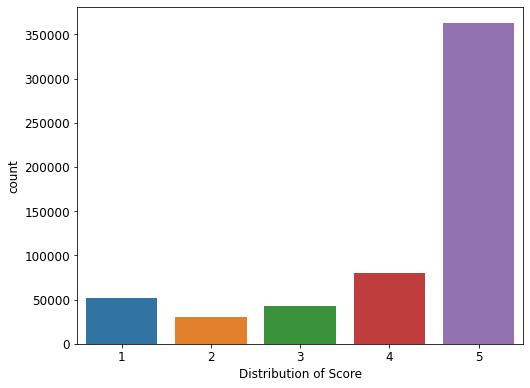

In [33]:
plt.figure()
sns.countplot(df['Score'])
plt.xlabel('Distribution of Score')
plt.show()

More than half of the reviews are rated 5 scores.

### 2.3 Sentiment Analysis

In [34]:
print(df['Sentiment'].value_counts())

positive    443777
negative    124677
Name: Sentiment, dtype: int64


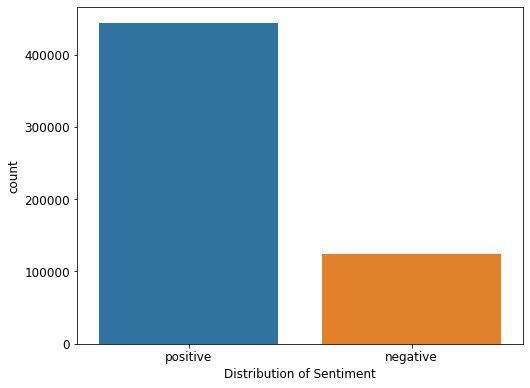

In [35]:
plt.figure()
sns.countplot(df['Sentiment'])
plt.xlabel('Distribution of Sentiment')
plt.show()

Majority reviews are consider positive

### 2.4 Usefulness Analysis

In [36]:
df.Usefulness.value_counts()

=0 (useless)             270052
>75%(very helpful)       202836
25%-75% (helpful)         57286
<25% (little helpful)     38280
Name: Usefulness, dtype: int64

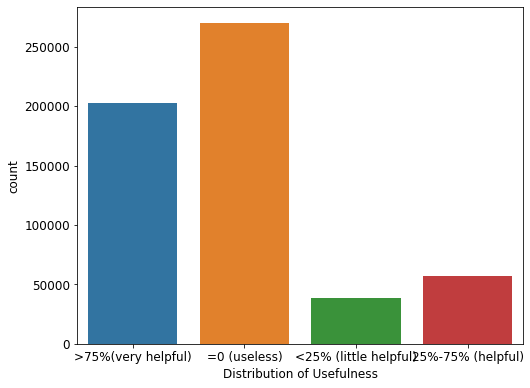

In [37]:
plt.figure()
sns.countplot(df['Usefulness'])
plt.xlabel('Distribution of Usefulness')
plt.show()

Within the reviewed being voted, 75% of the review are considered helpful.

### 2.5 Reviewers analysis

In [38]:
df.UserFrequency.value_counts()

Not frequent reviewer (0-100 reviews)    558778
frequent reviewer (>100 reviews)           9676
Name: UserFrequency, dtype: int64

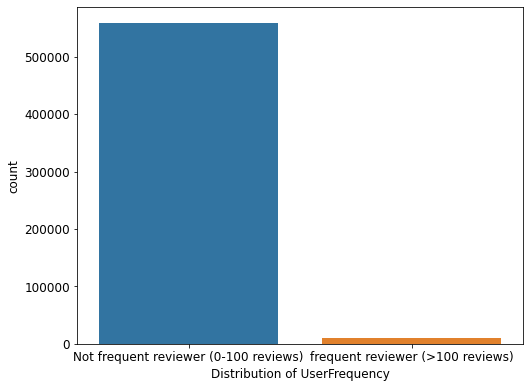

In [39]:
sns.countplot(df.UserFrequency)
plt.xlabel('Distribution of UserFrequency')
plt.show()

There are more non-frequent reviewers than frequent reviewers

### 2.6 Relationship analysis between variables
#### a) Are positive reveiws more helpful?

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

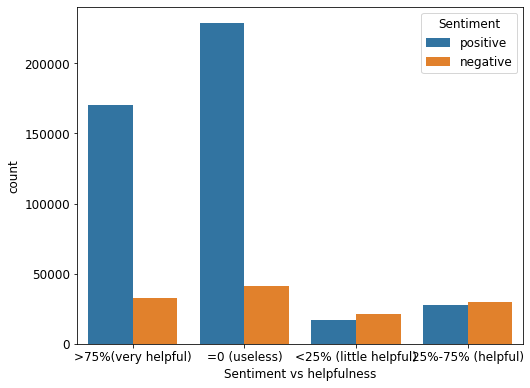

In [41]:
sns.countplot(x = df['Usefulness'], hue = df['Sentiment'])

plt.xlabel('Sentiment vs helpfulness')
plt.show()

Within the reviews being voted, more positive reviews than negative reviews within in very helpful (>75% voted) reviews, and more negative reviews than positive ones in helpful (25%-75% voted) reviews and little helpful (0-25% voted).

#### b) Are frequent reviewers more helpful? 

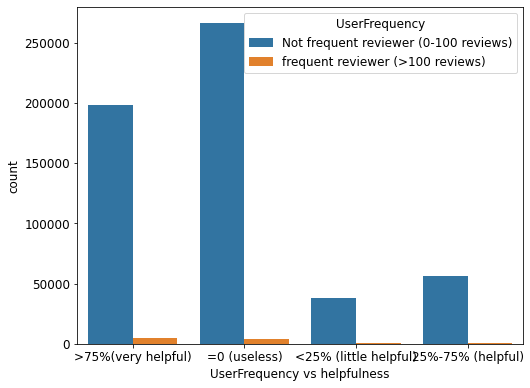

In [42]:
sns.countplot(x = df['Usefulness'], hue = df['UserFrequency'])

plt.xlabel('UserFrequency vs helpfulness')
plt.show()

No matter the usefulness of the review, more no-frequent reviewers's reviews than frequent reviewers' reviews.

### 3. Predictive Modeling        
In this section, we will:              
- split the dataset, 
- convert text into vectors 
- build model 

### Summary  
We first split the data into train and test dataset.                      
Three methods - uni-gram bag of words, bi-gram bag of words and tf-idf - were applied to covert the test and train datasets into vectors.              
Then we use logistic regression and random forest regression method to create the prediction model.                 
### 3.1 Test Train Data Split               
As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative".             

The data will be split into an training set and a test set with a test set ratio of 0.2

In [43]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size =0.2, random_state = 1)
print('%d items in training data, %d items in test data' % (len(train), len(test)))

454763 items in training data, 113691 items in test data


let's take a look at train data and test data

In [44]:
train = train.reset_index(drop = True)
train.head()

,Id,Score,Summary,Sentiment,Usefulness,UserFrequency,Summary_Clean
0,308347,5,The best espresso i've ever had,positive,>75%(very helpful),Not frequent reviewer (0-100 reviews),the best espresso ive ever had
1,74067,3,"False advertising, but tasty",negative,=0 (useless),Not frequent reviewer (0-100 reviews),fals advertis but tasti
2,125393,1,Deadly treat,negative,25%-75% (helpful),Not frequent reviewer (0-100 reviews),dead treat
3,173888,3,Too Strong,negative,<25% (little helpful),Not frequent reviewer (0-100 reviews),too strong
4,484232,4,Very Good Tea,positive,=0 (useless),Not frequent reviewer (0-100 reviews),veri good tea


In [45]:
test = test.reset_index(drop = True)
test.head()

,Id,Score,Summary,Sentiment,Usefulness,UserFrequency,Summary_Clean
0,288313,5,Cherry Pie Larabar,positive,=0 (useless),Not frequent reviewer (0-100 reviews),cherri pie larabar
1,431727,5,Melitta Coffee,positive,=0 (useless),Not frequent reviewer (0-100 reviews),melitta coffe
2,110312,5,great treat,positive,=0 (useless),Not frequent reviewer (0-100 reviews),great treat
3,91856,5,Daily Calming,positive,=0 (useless),Not frequent reviewer (0-100 reviews),daili calm
4,338856,5,Best Canned Artichokes Out There!,positive,25%-75% (helpful),Not frequent reviewer (0-100 reviews),best can artichok out there


### 3.2 Convert text to vector               
There are multiple ways to convert text to vector. In here, I will present 3 ways     
a) Uni-gram bag of words     
b) Bi-gram bag of words      
c) tf-idf

- Bag of Words (BOW)
The bag-of-words represents the frequency of occurence of each word used as a feature in the document.                 
n-gram means a contiguous sequence of n items. Thus n-gram BOW represent the frequency of occurence of n contiguous word appeared in the document. In this project, only 1-gram and 2-gram were applied. Thus, uni-gram represent the frequency of each words appeared in the document, bi-gram represent a 2 contiguous words appeared in the document.     
             
             
- TF-IDF
Tf-Idf is an information retrieval technique that weighs a term's frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term

![alt text](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

In [47]:
train['Summary_Clean'].values

array(['the best espresso ive ever had', 'fals advertis but tasti',
       'dead treat', ..., 'best waffel mix ever', 'tri it youll love it',
       'not worth the money'], dtype=object)

#### a) Uni-gram bag of words

In [48]:
uni_gram = CountVectorizer(min_df = 5, binary = True) # only use keyword which shows up more than 5 times. 
uni_gram_vectors_train = uni_gram.fit_transform(train['Summary_Clean'].values)
uni_gram_vectors_test = uni_gram.transform(test['Summary_Clean'].values)

In [49]:
uni_gram_vectors_train.shape

(454763, 8173)

In [50]:
uni_gram_feature = uni_gram.get_feature_names()
uni_gram_feature[-10:] #have a peek of last 10 uni_gram features

['zoe',
 'zola',
 'zombi',
 'zone',
 'zoo',
 'zoom',
 'zot',
 'zotz',
 'zsweet',
 'zuke']

#### b) Bi-gram BOW

In [51]:
                                        # 1 means the minimum is unigram, 2 means max is bigrams, 
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) 
bi_gram_vectors_train = bi_gram.fit_transform(train['Summary_Clean'].values)
bi_gram_vectors_test = bi_gram.transform(test['Summary_Clean'].values)

In [52]:
bi_gram_vectors_train.shape

(454763, 46964)

In [53]:
bi_gram_features = bi_gram.get_feature_names()
bi_gram_features[-10:] #have a peek of last 10 bi_gram features

['zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke product',
 'zuke treat']

#### c) tf-idf

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = 5)
tfidf_vectors_train = tfidf.fit_transform(train['Summary_Clean'].values)
tfidf_vectors_test = tfidf.transform(test['Summary_Clean'].values)

In [55]:
tfidf_vectors_train.shape

(454763, 46964)

In [56]:
tfidf_features = tfidf.get_feature_names()
tfidf_features[-10:]

['zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke product',
 'zuke treat']

Now let's build model

In [57]:
prediction = dict()
prob = dict()

### 3.3 Logistic Regression
#### a) Using uni-gram BOW

In [58]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [59]:
logreg_uni_gram = LogisticRegression(max_iter = 1000)
#Receive warning that total of iterations reached limit, thus set the max_iter (default is 1000)
#build model
logreg_uni_gram_model = logreg_uni_gram.fit(uni_gram_vectors_train, train['Sentiment'])
#use model on test data for prediction
prediction['logreg_uni_gram'] = logreg_uni_gram_model.predict(uni_gram_vectors_test)
prob['logreg_uni_gram'] = logreg_uni_gram_model.predict_proba(uni_gram_vectors_test)

In [60]:
import collections
print('test data using Uni_gram BOW')
print(test['Sentiment'].value_counts())
print('------------------------------')
print('predicted data')
print(collections.Counter(prediction['logreg_uni_gram']))

test data using Uni_gram BOW
positive    88777
negative    24914
Name: Sentiment, dtype: int64
------------------------------
predicted data
Counter({'positive': 93947, 'negative': 19744})


#### b) Using bi_gram BOW

In [61]:
logreg_bi_gram = LogisticRegression(max_iter = 1000)
#Receive warning that total of iterations reached limit, thus set the max_iter (default is 1000)
#build model
logreg_bi_gram_model = logreg_bi_gram.fit(bi_gram_vectors_train, train['Sentiment'])
#use model on test data for prediction
prediction['logreg_bi_gram'] = logreg_bi_gram_model.predict(bi_gram_vectors_test)
prob['logreg_bi_gram'] = logreg_bi_gram_model.predict_proba(bi_gram_vectors_test)

In [62]:
import collections
print('test data using Bi_gram BOW')
print(test['Sentiment'].value_counts())
print('------------------------------')
print('predicted data')
print(collections.Counter(prediction['logreg_bi_gram']))

test data using Bi_gram BOW
positive    88777
negative    24914
Name: Sentiment, dtype: int64
------------------------------
predicted data
Counter({'positive': 92153, 'negative': 21538})


#### c) Using tf-idf

In [63]:
logreg_tfidf = LogisticRegression(max_iter = 1000)
#Receive warning that total of iterations reached limit, thus set the max_iter (default is 1000)
#build model
logreg_tfidf_model = logreg_tfidf.fit(tfidf_vectors_train, train['Sentiment'])
#use model on test data for prediction
prediction['logreg_tfidf'] = logreg_tfidf_model.predict(tfidf_vectors_test)
prob['logreg_tfidf'] = logreg_tfidf_model.predict_proba(tfidf_vectors_test)

In [64]:
import collections
print('test data using tfidf')
print(test['Sentiment'].value_counts())
print('------------------------------')
print('predicted data')
print(collections.Counter(prediction['logreg_tfidf']))

test data using tfidf
positive    88777
negative    24914
Name: Sentiment, dtype: int64
------------------------------
predicted data
Counter({'positive': 92807, 'negative': 20884})


### 3.4 Random Forest Regression                  
#### a) Using uni-gram BOW

In [65]:
from sklearn.ensemble import RandomForestClassifier
from time import process_time
t2_start=process_time()

#build model
rf_uni_gram = RandomForestClassifier(max_depth=100)
rf_uni_gram_model=rf_uni_gram.fit(uni_gram_vectors_train, train['Sentiment'].values)

#use model for prdiction
prediction['rf_uni_gram'] = rf_uni_gram_model.predict(uni_gram_vectors_test)
prob['rf_uni_gram']=rf_uni_gram_model.predict_proba(uni_gram_vectors_test)

t2_stop=process_time()
print('Elapsed time:', t2_stop-t2_start)

Elapsed time: 920.265625


In [66]:
import collections
print('test data')
print(test['Sentiment'].value_counts())
print('-------------')
print('predicted data')
print(collections.Counter(prediction['rf_uni_gram']))

test data
positive    88777
negative    24914
Name: Sentiment, dtype: int64
-------------
predicted data
Counter({'positive': 98981, 'negative': 14710})


#### b) Using bi_gram BOW

In [67]:
from time import process_time
t2_start=process_time()

#build model
rf_bi_gram = RandomForestClassifier(max_depth=100)
rf_bi_gram_model =rf_bi_gram.fit(bi_gram_vectors_train, train['Sentiment'].values)

#use model for prdiction
prediction['rf_bi_gram'] = rf_bi_gram_model.predict(bi_gram_vectors_test)
prob['rf_bi_gram']=rf_bi_gram_model.predict_proba(bi_gram_vectors_test)

t2_stop=process_time()
print('Elapsed time:', t2_stop-t2_start)

Elapsed time: 1228.390625


In [68]:
import collections
print('test data')
print(test['Sentiment'].value_counts())
print('-------------')
print('predicted data')
print(collections.Counter(prediction['rf_bi_gram']))

test data
positive    88777
negative    24914
Name: Sentiment, dtype: int64
-------------
predicted data
Counter({'positive': 104753, 'negative': 8938})


#### c) Using tf-idf

In [69]:
from time import process_time
t2_start=process_time()

#build model
rf_tfidf = RandomForestClassifier(max_depth=100)
rf_tfidf_model=rf_tfidf.fit(tfidf_vectors_train, train['Sentiment'].values)

#use model for prdiction
prediction['rf_tfidf'] = rf_tfidf_model.predict(tfidf_vectors_test)
prob['rf_tfidf']=rf_tfidf_model.predict_proba(tfidf_vectors_test)

t2_stop=process_time()
print('Elapsed time:', t2_stop-t2_start)

Elapsed time: 1239.6875


In [70]:
import collections
print('test data')
print(test['Sentiment'].value_counts())
print('-------------')
print('predicted data')
print(collections.Counter(prediction['rf_tfidf']))

test data
positive    88777
negative    24914
Name: Sentiment, dtype: int64
-------------
predicted data
Counter({'positive': 105213, 'negative': 8478})


## 4. Predictive and Evaluation
In this section, we will use the test data split from the dataset to test the model performances. We will compare among 3 logistic models and among 3 random forest regression models to find the best performance model.           

### Summary
- Logistic regression models using Bi-gram and TF-IDF have the highest accuracy rate (0.92). Still, the logistic regression model used bi-gram has a higher f1-score, a higher area under the ROC curve, and hence the logistic model using bi-gram BOW performs the best among three.            
- andom forest regression models all have a very closed accuracy rate, but the random forest using uni-gram BOW has the highest accuracy rate, f1 score, and area under the curve, and hen the random forest regression model performs using uni-gram perform the best among three.             
- Comparison between the best logistic regression model and the random forest regression model, the logistic regression model using the bi-gram BOW performs the best.            

#### 4.1 Comparison of 3 logistic models
In order to compare our learning algorithms, let's build the ROC(Receiver Operating Characteristic) curve.        
The curve with the highest AUC (Area under the ROC Curve) measure of performance across all possible classification thresholds, thus the highest AUC (Area under the ROC Curve) value will show our "best" algorithm.      

#### a) Comparison of Classification report 

- The classification report measures the quality of the prediction model. It tells us the precision, reall, and f1 score on the basis of each label.                 
- The metrics are calculated by using true positive (TP), false positive (FP), true negative (TN) and false negative (FN).      
    - precision evaluates the accuracy of the positive predicitions.                         
        Precision = TP/(TP + FP)
    - recall evaluates the the percentage correct identified positives. 
        Recall = TP/(TP+FN)
    - F1 score weights the precision and recall, measure the test's accuracy.            
        F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [71]:
from sklearn import metrics
from sklearn.metrics import classification_report
print('Logistic Regression using uni-gram BOW:')
print(metrics.classification_report(test['Sentiment'].values,
                                   prediction['logreg_uni_gram'],
                                   target_names = ['negative', 'positive']))
print('Logistic Regression using bi-gram BOW:')
print(metrics.classification_report(test['Sentiment'].values,
                                   prediction['logreg_bi_gram'],
                                   target_names = ['negative', 'positive']))
print('Logistic Regression using tf-idf:')
print(metrics.classification_report(test['Sentiment'].values,
                                   prediction['logreg_tfidf'],
                                   target_names = ['negative', 'positive']))

Logistic Regression using uni-gram BOW:
              precision    recall  f1-score   support

    negative       0.81      0.64      0.72     24914
    positive       0.91      0.96      0.93     88777

    accuracy                           0.89    113691
   macro avg       0.86      0.80      0.82    113691
weighted avg       0.88      0.89      0.88    113691

Logistic Regression using bi-gram BOW:
              precision    recall  f1-score   support

    negative       0.87      0.75      0.81     24914
    positive       0.93      0.97      0.95     88777

    accuracy                           0.92    113691
   macro avg       0.90      0.86      0.88    113691
weighted avg       0.92      0.92      0.92    113691

Logistic Regression using tf-idf:
              precision    recall  f1-score   support

    negative       0.87      0.73      0.79     24914
    positive       0.93      0.97      0.95     88777

    accuracy                           0.92    113691
   macro avg   

Logistic regression models using Bi-gram and tf-idf have highest accuracy rate (0.92), but logistic regression model used bi-gram has higher f1-score than the one used tf-idf. Thus, logistic regression model used bi-gram perform the best under under current metric.

#### b) Comparison of AUC value
- AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1) AUC measures the performance of the model prediction and it is nor related to what classification is choosen.                
- An model with AUC value eqal to 0 means the prediction of the model is 100% wrong, and AUC value equal to 1.0 means the prediciton of the model is 100% correct. 

In [72]:
prob['no_skill']=[0 for _ in range(len(test['Sentiment'].values))]

In [73]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# get all auc value
auc_noskill = roc_auc_score(test['Sentiment'].values, prob['no_skill'])
auc_log_uni = roc_auc_score(test['Sentiment'].values, prob['logreg_uni_gram'] [:,1])
auc_log_bi = roc_auc_score(test['Sentiment'].values, prob['logreg_bi_gram'] [:,1])
auc_log_tfidf = roc_auc_score(test['Sentiment'].values, prob['logreg_tfidf'] [:,1])

print('auc for no skill: ROC AUC =%.3f' % (auc_noskill))
print('auc for logistic using Uni_gram BOW: ROC AUC =%.3f' % (auc_log_uni))
print('auc for logistic using Bi_gram BOW: ROC AUC =%.3f' % (auc_log_bi))
print('auc for logistic using tfidf: ROC AUC =%.3f' % (auc_log_tfidf))

auc for no skill: ROC AUC =0.500
auc for logistic using Uni_gram BOW: ROC AUC =0.928
auc for logistic using Bi_gram BOW: ROC AUC =0.956
auc for logistic using tfidf: ROC AUC =0.955


The highest AUC value is the logistic model using bi-gram BOW. This means the logistic regression model using bi-gram BOW predicts 95.6%.

#### c) Comparison of ROC curve

ROC curve stands for Receiver operating characteristic. The curve created by plotting TP rate against FP rate at various threshold settings. And AUC is the area under ROC curve. 

In [74]:
# calculate roc curves
nomodel_fpr, nomodel_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['no_skill'], pos_label='positive')
log_uni_gram_fpr, log_uni_gram_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['logreg_uni_gram'][:,1], pos_label='positive')
log_bi_gram_fpr, log_bi_gram_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['logreg_bi_gram'][:,1], pos_label='positive')
log_tfidf_fpr, log_tfidf_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['logreg_tfidf'][:,1], pos_label='positive')

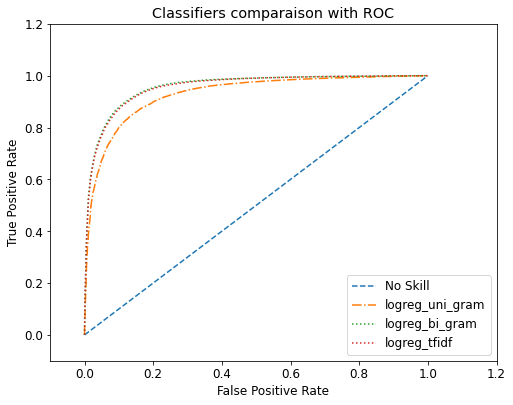

In [75]:
#then plot the roc curve
from matplotlib import pyplot
pyplot.plot(nomodel_fpr, nomodel_tpr, linestyle ='--', label ='No Skill')
pyplot.plot(log_uni_gram_fpr, log_uni_gram_tpr, linestyle ='-.', label ='logreg_uni_gram')
pyplot.plot(log_bi_gram_fpr, log_bi_gram_tpr, linestyle =':', label ='logreg_bi_gram')
pyplot.plot(log_tfidf_fpr, log_tfidf_tpr, linestyle ='dotted', label ='logreg_tfidf')

#add label and ledgend
pyplot.legend()
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.show()

From the above curve, it can be seen that logisitc regression with bi-gram BOW is very close to the logistic regression using uni-gram BOW. Logistic regression using bi-gram BOW is slightly higer than the one with un-gram BOW, and has the highest area uder the ROC curve and hence, seems to be the best model according to this metric.

### 4.2 Comparison of 3 Random Forest Regression Model
#### a) Comparison of Classification report

In [89]:
print('Random Forest Regression using uni-gram BOW:')
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['rf_uni_gram'], 
                                    target_names = ["negative", "positive"]))
print('Random Forest Regression using bi-gram BOW:')
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['rf_bi_gram'], 
                                    target_names = ["negative", "positive"]))
print('Random Forest Regression using tf-idf:')
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['rf_tfidf'], 
                                    target_names = ["negative", "positive"]))

Random Forest Regression using uni-gram BOW:
              precision    recall  f1-score   support

    negative       0.91      0.54      0.68     24914
    positive       0.88      0.99      0.93     88777

    accuracy                           0.89    113691
   macro avg       0.90      0.76      0.80    113691
weighted avg       0.89      0.89      0.88    113691

Random Forest Regression using bi-gram BOW:
              precision    recall  f1-score   support

    negative       0.94      0.34      0.50     24914
    positive       0.84      0.99      0.91     88777

    accuracy                           0.85    113691
   macro avg       0.89      0.67      0.70    113691
weighted avg       0.86      0.85      0.82    113691

Random Forest Regression using tf-idf:
              precision    recall  f1-score   support

    negative       0.94      0.32      0.48     24914
    positive       0.84      0.99      0.91     88777

    accuracy                           0.85    113691


The random forest regression has very close accuracy rate, the random forest regression using uni-gram BOW has the highest accuracy rate(0.89). In addition, random forest regression using uni-gram BOW has the highest f1 score. Thus, random forest regression model used uni-gram perform the best under current metrics. 

#### b) Comparison of AUC value

In [79]:
prob['no_skill']=[0 for _ in range(len(test['Sentiment'].values))]

In [80]:
# get all auc value
auc_noskill = roc_auc_score(test['Sentiment'].values, prob['no_skill'])
auc_rf_uni = roc_auc_score(test['Sentiment'].values, prob['rf_uni_gram'] [:,1])
auc_rf_bi = roc_auc_score(test['Sentiment'].values, prob['rf_bi_gram'] [:,1])
auc_rf_tfidf = roc_auc_score(test['Sentiment'].values, prob['rf_tfidf'] [:,1])

print('auc for no skill: ROC AUC =%.3f' % (auc_noskill))
print('auc for radom forest using Uni_gram BOW: ROC AUC =%.3f' % (auc_rf_uni))
print('auc for radom forest using Bi_gram BOW: ROC AUC =%.3f' % (auc_rf_bi))
print('auc for radom forest using tfidf: ROC AUC =%.3f' % (auc_rf_tfidf))

auc for no skill: ROC AUC =0.500
auc for radom forest using Uni_gram BOW: ROC AUC =0.941
auc for radom forest using Bi_gram BOW: ROC AUC =0.936
auc for radom forest using tfidf: ROC AUC =0.935


The random forest regression model using uni-gram BOW has the highest AUC value, which means this prediction model is 94.1% correct.

#### c) Comparison of ROC curve

In [84]:
# calculate roc curves
nomodel_fpr, nomodel_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['no_skill'], pos_label='positive')
rf_uni_gram_fpr, rf_uni_gram_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['rf_uni_gram'][:,1], pos_label='positive')
rf_bi_gram_fpr, rf_bi_gram_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['rf_bi_gram'][:,1], pos_label='positive')
rf_tfidf_fpr, rf_tfidf_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['rf_tfidf'][:,1], pos_label='positive')

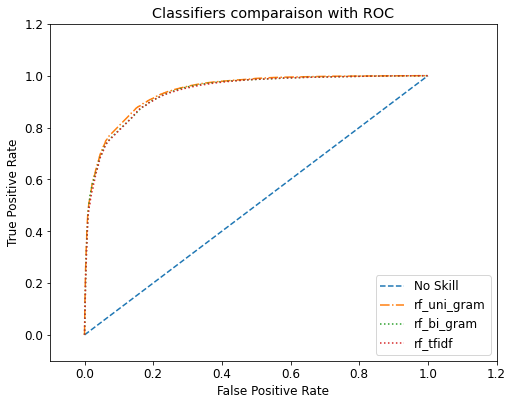

In [85]:
#then plot the roc curve
from matplotlib import pyplot
pyplot.plot(nomodel_fpr, nomodel_tpr, linestyle ='--', label ='No Skill')
pyplot.plot(rf_uni_gram_fpr, rf_uni_gram_tpr, linestyle ='-.', label ='rf_uni_gram')
pyplot.plot(rf_bi_gram_fpr, rf_bi_gram_tpr, linestyle =':', label ='rf_bi_gram')
pyplot.plot(rf_tfidf_fpr, rf_tfidf_tpr, linestyle ='dotted', label ='rf_tfidf')

#add label and ledgend
pyplot.legend()
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.show()

From the above curve, it can be seen that all three ROC curve is very close. However, we still can see the random forest regression using uni-gram BOW seems has the highest area under the ROC curve and hens, seems to be the best model under current metrics. 

### 4.3 Comparison between Logistic Regression Model and Random Forest Regression Model  


In [104]:
auc_log_bi = roc_auc_score(test['Sentiment'].values, prob['logreg_bi_gram'] [:,1])
auc_rf_uni = roc_auc_score(test['Sentiment'].values, prob['rf_uni_gram'] [:,1])

print('auc for logistic using Bi_gram BOW: ROC AUC =%.3f' % (auc_log_bi))
print('auc for radom forest using Uni_gram BOW: ROC AUC =%.3f' % (auc_rf_uni))

auc for logistic using Bi_gram BOW: ROC AUC =0.956
auc for radom forest using Uni_gram BOW: ROC AUC =0.941


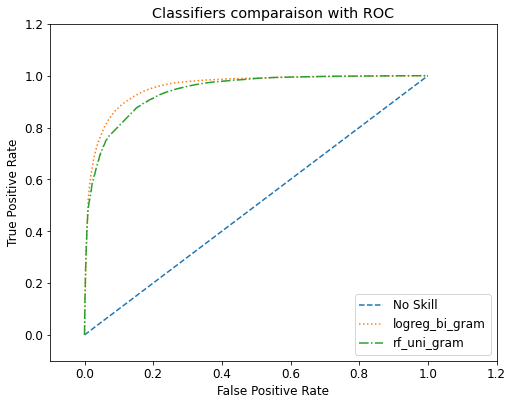

In [86]:
#calculate roc curves
nomodel_fpr, nomodel_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['no_skill'], pos_label='positive')
log_bi_gram_fpr, log_bi_gram_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['logreg_bi_gram'][:,1], pos_label='positive')
rf_uni_gram_fpr, rf_uni_gram_tpr, _ = \
        roc_curve(test['Sentiment'].values, prob['rf_uni_gram'][:,1], pos_label='positive')

#then plot the roc curve
from matplotlib import pyplot
pyplot.plot(nomodel_fpr, nomodel_tpr, linestyle ='--', label ='No Skill')
pyplot.plot(log_bi_gram_fpr, log_bi_gram_tpr, linestyle =':', label ='logreg_bi_gram')
pyplot.plot(rf_uni_gram_fpr, rf_uni_gram_tpr, linestyle ='-.', label ='rf_uni_gram')

#add label and ledgend
pyplot.legend()
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.show()

In logistic model, bi-gram BOW has the highest AUC (0.96) which is greater than the random forest using Uni_gram BOW (0.941). Thus, the best model is logistic model using bi-gram BOW.

## 5. Conclusion

- In this notebook, we are trying to build a model that can predict whether reviews are positive or negative. In this sense, we intentionally ignored the review rated 3 scores.
- After we created new variables and converted the variable into the desired data type, we performed various techniques to build a term-doc incidence matrix and displayed the cloud word to get a sense of the data. 
- In the exploratory data analysis, we used plots to show the distribution of score, sentiment, usefulness, reviewers, and the relationship between those variables.
- To build a proper model, we used three different methods to vectorize the text and then applied each one with the logistic regression method and the random forest regression method. 
- In the end, we used three different metrics to find the best logistic model and the best random forest model. We also compared the best logistic model and the best random forest regression model. The logistic regression model using a bi-gram BOW performs the best compared to the other two logistic regression models. The random forest regression model using the uni-gram BOW performs the best compared to the other two random forest regression models. Overall, the logistic regression model using bi-gram BOW has the highest accuracy, f1 score, and area under the curve, and hence, the best model under current metrics. 